### Delivery Time Distribution

Analyzing based on the result of `Data Hygiene`.
    
Filter out all deliveries recorded after a certain hour (e.g., 9 PM) and re-run your delivery time distribution.

Compare the 'Cleaned' Mean vs. 'Original' Mean. You will likely find that the average delivery time drops significantly once you remove these human-entry outliers.

#### Loading Datasets

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from utils import read_orders, read_customers

In [2]:
od = read_orders()
cs = read_customers()

In [3]:
df = pd.merge(od, cs[['customer_id', 'state']], on='customer_id', how='left')

In [4]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP


In [5]:
df['hour'] = df['order_delivered_customer_date'].dt.hour
df['is_after_hours'] = (df['hour']  >= 22) | (df['hour']  < 6)

df['total_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

In [6]:
def draw_boxplot(x, y, df):
# Create a box plot grouping data by day of the week
    fig, ax = plt.subplots(figsize=(10, 6)) #

    sns.boxplot(x=x, y=y, data=df, ax = ax)
    plt.show()

#### Original Mean
`12.09`

In [7]:
df['total_days'].describe()

count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: total_days, dtype: float64

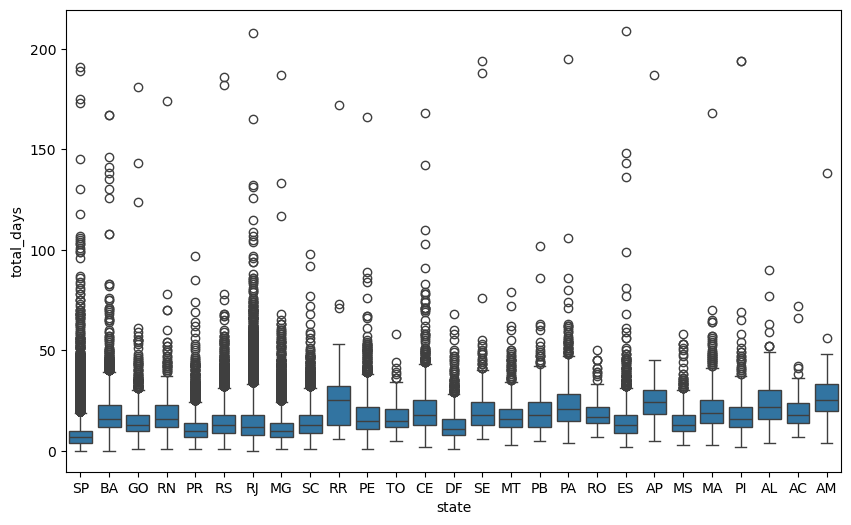

In [8]:
draw_boxplot('state', 'total_days', df)

In [ ]:
draw_boxplot('state', 'total_days', df)

#### Cleaned Mean
`11.92`

In [9]:
condition = ~df['is_after_hours'] 
df[condition]['total_days'].describe()

count    80201.000000
mean        11.920936
std          9.466638
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: total_days, dtype: float64

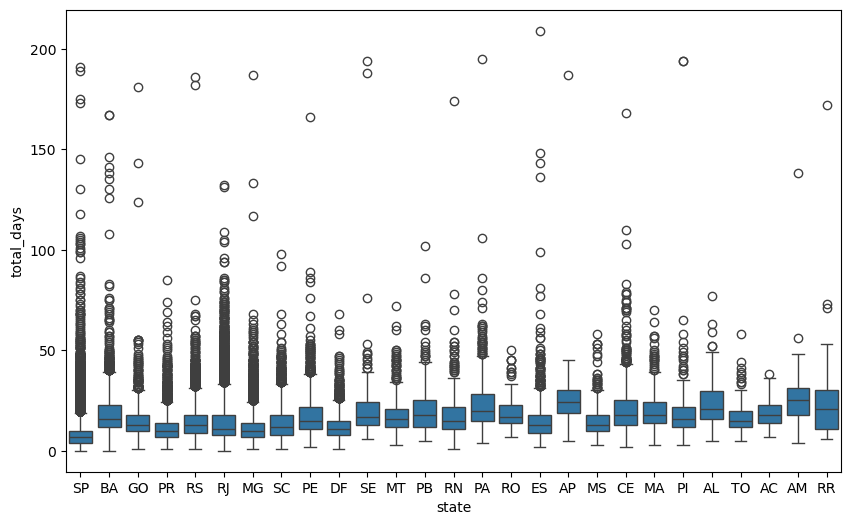

In [10]:
draw_boxplot('state', 'total_days', df[condition])

### Action

Outliers are "Long Tail" outliers, not just "Midnight Spikes."


Even though the night-time reporting is a statistically significant habit, it isn't the primary driver of the high average delivery time. This means the root cause of your efficiency problem is likely physical, not just an administrative data-entry error.

### Density of Deliveries per Hour

**The Logic**: If the mean isn't shifting, it means you have orders that are taking a long time during the day as well.

**The Test**: Group your data by hour and calculate the Standard Deviation $(\sigma)$ for each hour.


In [11]:
new_df = df[['hour', 'total_days']]
new_df = new_df.groupby('hour').agg(['mean', 'std']).reset_index()
new_df.head()

hour total_days           
             mean        std
0  0.0  13.337608  10.325882
1  1.0  13.128713   9.832007
2  2.0  13.375963   9.909332
3  3.0  13.003846   8.454967
4  4.0  12.331551   9.166161

In [12]:
new_df.describe()

hour total_days           
                       mean        std
count  24.000000  24.000000  24.000000
mean   11.500000  12.395357   9.404085
std     7.071068   0.683037   0.730938
min     0.000000  11.594355   7.307970
25%     5.750000  11.953680   9.129164
50%    11.500000  12.148314   9.305212
75%    17.250000  12.646656   9.851338
max    23.000000  14.474747  10.888077

### Finding
Your "average" performance is relatively stable throughout the day.

Real problem is that our process is "High Variance". This means if a customer is told a delivery takes 13 days, there is a very high statistical probability it could actually take 3 days or 23 days.

Since your SD is high across all hours, the root cause is "Process Noise."

### Density of Deliveries per Day

In [13]:
df['day_name'] = df['order_delivered_carrier_date'].dt.day_name()

new_df = df[['day_name', 'total_days']]
new_df = new_df.groupby('day_name').agg(['mean', 'std']).reset_index()
new_df

day_name total_days           
                   mean        std
0     Friday  12.337692   9.407641
1     Monday  11.703375   9.415450
2   Saturday  14.039728   9.993388
3     Sunday  24.416667  11.266575
4   Thursday  12.100930   9.586108
5    Tuesday  12.050718   9.658711
6  Wednesday  12.116232   9.573339

In [14]:
# Define conditions
conditions = [
    (df['day_name'] == 'Sunday'),
    (df['day_name'] == 'Saturday'),
]

# Define corresponding choices
choices = ['Sunday', 'Saturday']

# Use numpy.select to create the new column
df['day_name'] = np.select(conditions, choices, default='Weekday')

new_df = df[['day_name', 'total_days']]
new_df = new_df.groupby('day_name').agg(['mean', 'std']).reset_index()
new_df

day_name total_days           
                  mean        std
0  Saturday  14.039728   9.993388
1    Sunday  24.416667  11.266575
2   Weekday  12.053191   9.535941

In [15]:
df['day_name'] = df['order_purchase_timestamp'].dt.day_name()

new_df = df[['day_name', 'total_days']]
new_df = new_df.groupby('day_name').agg(['mean', 'std']).reset_index()
new_df

day_name total_days           
                   mean        std
0     Friday  13.117793   9.542816
1     Monday  11.536649   9.489473
2   Saturday  12.894183   9.795632
3     Sunday  11.475073   9.020380
4   Thursday  12.280198   9.163805
5    Tuesday  11.610566   9.586745
6  Wednesday  11.983282  10.043849

In [16]:
df['day_name'] = df['order_purchase_timestamp'].dt.day_name()
df['days_to_carrier'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']).dt.days
new_df = df[['day_name', 'days_to_carrier']]
new_df = new_df.groupby('day_name').agg(['mean', 'std']).reset_index()
new_df

day_name days_to_carrier          
                        mean       std
0     Friday        3.734742  3.467928
1     Monday        2.221607  3.692588
2   Saturday        3.384917  3.326129
3     Sunday        2.337297  2.953393
4   Thursday        2.890944  3.713767
5    Tuesday        2.354958  3.812812
6  Wednesday        2.506639  3.827774

### More Proof about After Hours Deliveries

In [17]:
test = df[df['is_after_hours']]
test['day_name'] = df['order_delivered_customer_date'].dt.day_name()
test['day_name'].value_counts()

C:\Users\sawyu\AppData\Local\Temp\ipykernel_10980\886845317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['day_name'] = df['order_delivered_customer_date'].dt.day_name()


day_name
Tuesday      3353
Wednesday    3183
Friday       3094
Thursday     3081
Monday       2401
Saturday     1133
Sunday         30
Name: count, dtype: int64

In [25]:
df['day_name'] = df['order_delivered_customer_date'].dt.day_name()
df['day_name'].value_counts()

day_name
Monday       18892
Tuesday      18493
Wednesday    18059
Friday       17265
Thursday     17097
Saturday      5463
Sunday        1207
Name: count, dtype: int64

C:\Users\sawyu\AppData\Local\Temp\ipykernel_10980\375302413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['day'] = df['order_delivered_customer_date'].dt.day


<Axes: xlabel='day'>

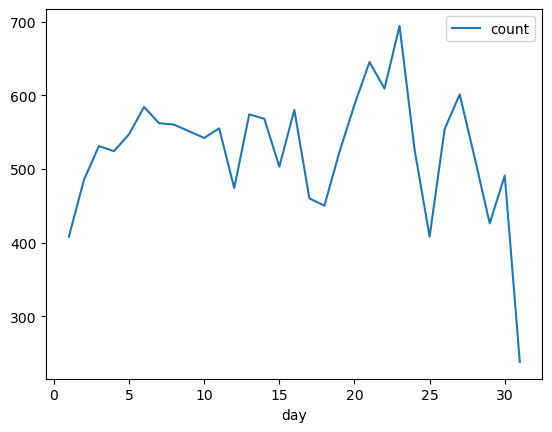

In [24]:
test = df[df['is_after_hours']]
test['day'] = df['order_delivered_customer_date'].dt.day
chart = test['day'].value_counts().to_frame().sort_values(by="day")
chart.plot()


### Finding
`order_delivered_carrier_date` have double mean time than on Sunday days than in week-days.